In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

import sys
import os 

os.environ["CONFIG_PATHS"] = "../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_10"'
sys.path.append("../src")

from display import Display
from analysis.load_events import load_events
from analysis.plots import *
from configuration import moves_data

In [9]:
events = load_events(
    "../data/2024-11-19_08-38-28-extracted/logs_2024-11-19_21-38-47_065883-pernor.txt"
)

Start time: 1732080905.369805


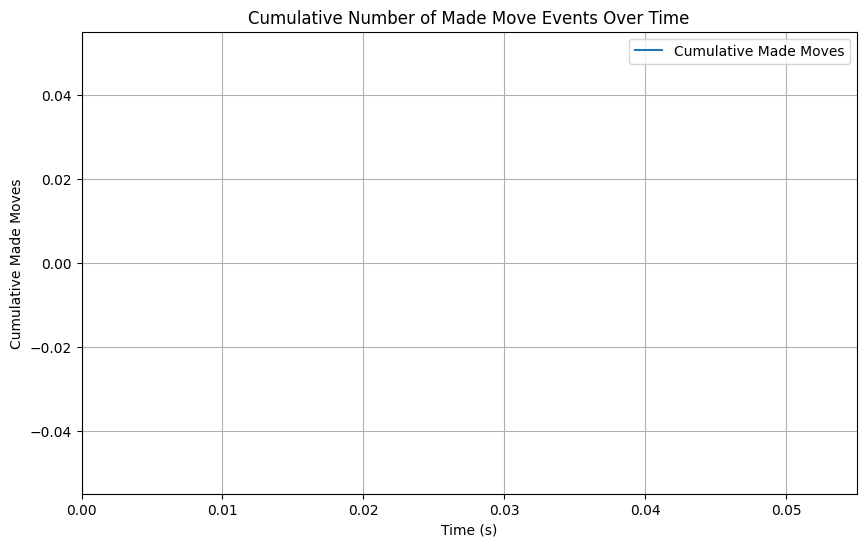

ValueError: min() arg is an empty sequence

Number of moves 1431586


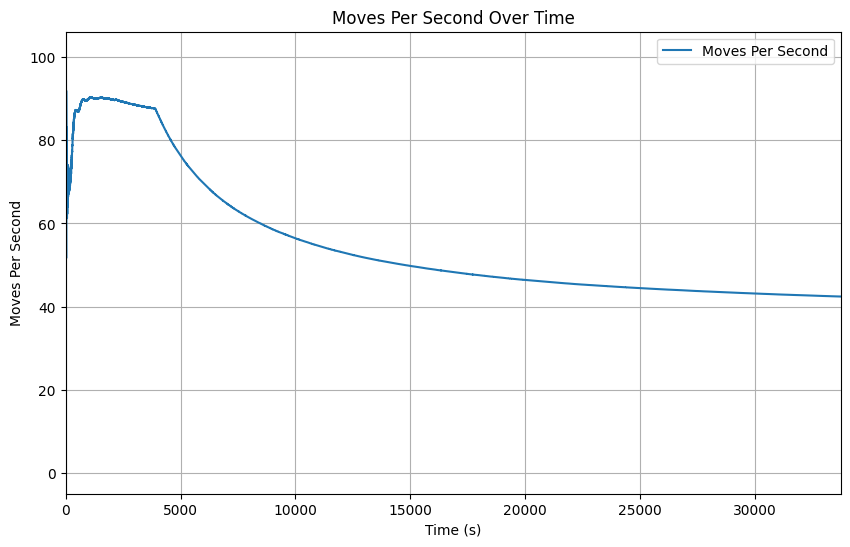

Maximal moves per second during latter half: 50.58680308644466


In [34]:


# GPU bottleneck. Closer to 1 means that the GPU is the bottleneck because the
# moves per second we actually got is close to the theoretical maximum based on
# GPU evaluation speed.
# 
# This won't work when using caching.
print("speed relative to if GPU was fully utilized:", final_moves_per_sec / ((total_evaluated / total_duration) / (500 * 0.2 + 100 * 0.8)))

speed relative to if GPU was fully utilized: 1.4741868863068195


In [35]:
# What percent of time is the GPU thread being used?

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.9319941478652403


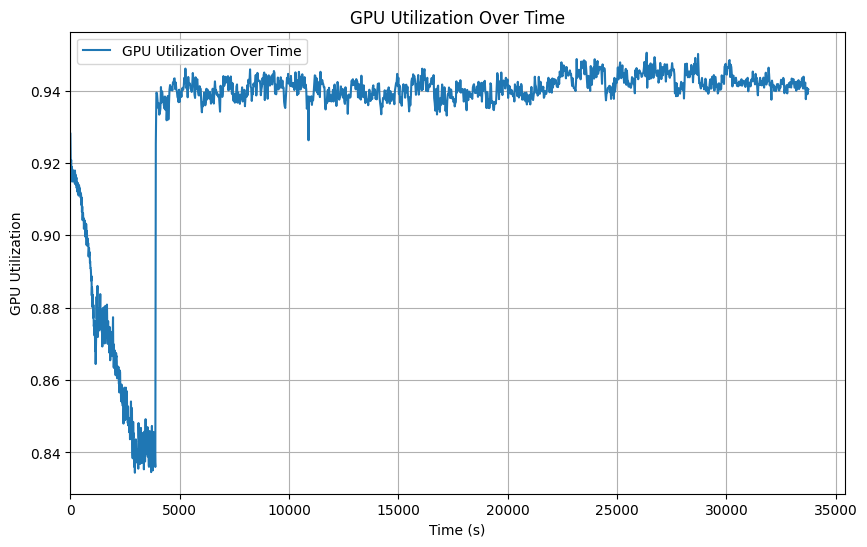

/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_68975/532304626.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


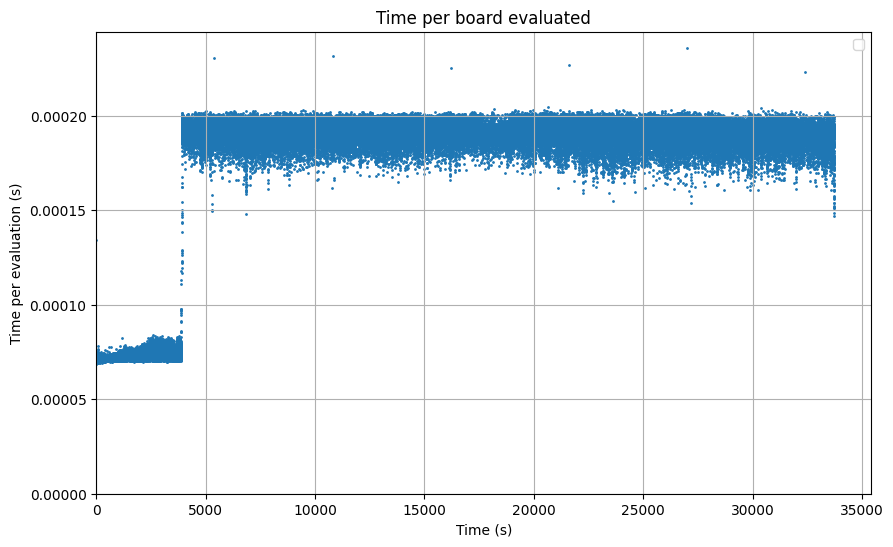

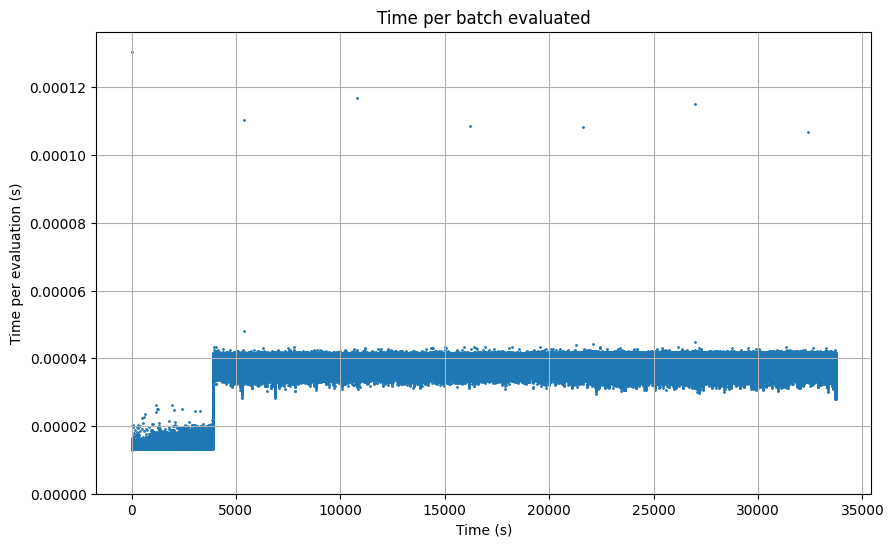

128.0

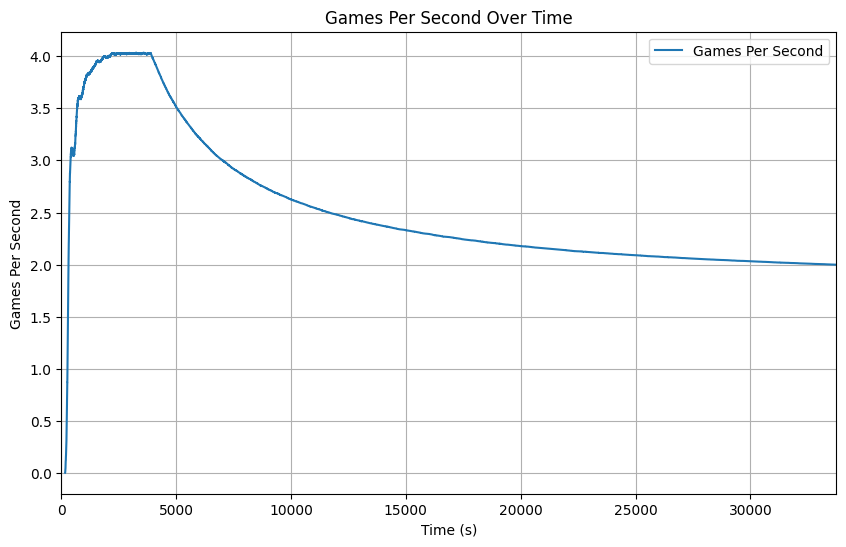

In [40]:
games_per_second = []

games_finished = 0
for event in events:
    if event[1] != "game_end":
        continue
    games_finished += 1

    games_per_second.append(games_finished / event[0])

plt.figure(figsize=(10, 6))
plt.plot([event[0] for event in events if event[1] == "game_end"], games_per_second, label='Games Per Second')
plt.xlabel('Time (s)')
plt.ylabel('Games Per Second')
plt.title('Games Per Second Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0, right=max(e[0] for e in events))
plt.show()

Slope: 1.8671837029227838
Intercept: 5886.04541541775
R-squared: 0.9910685315983909


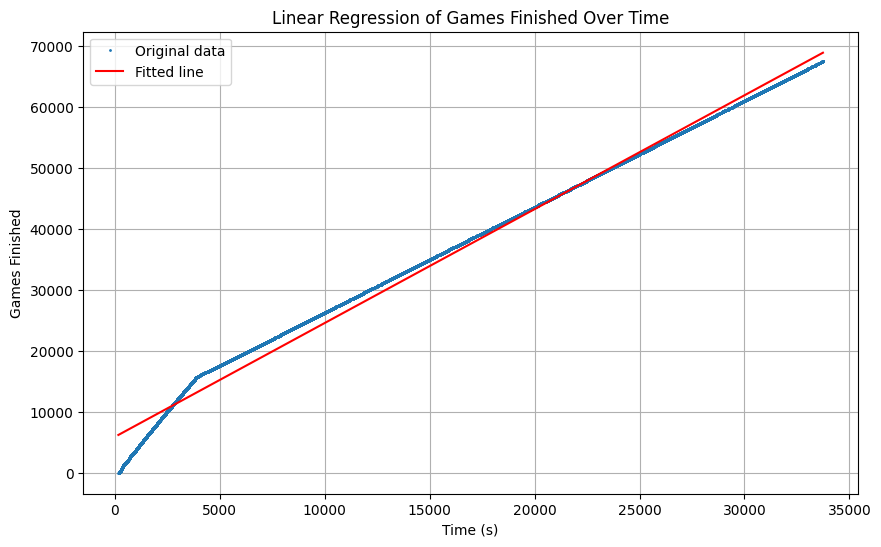

Slope: 87.12414046457295
Intercept: 296038.1002090215
R-squared: 0.9904644858514947


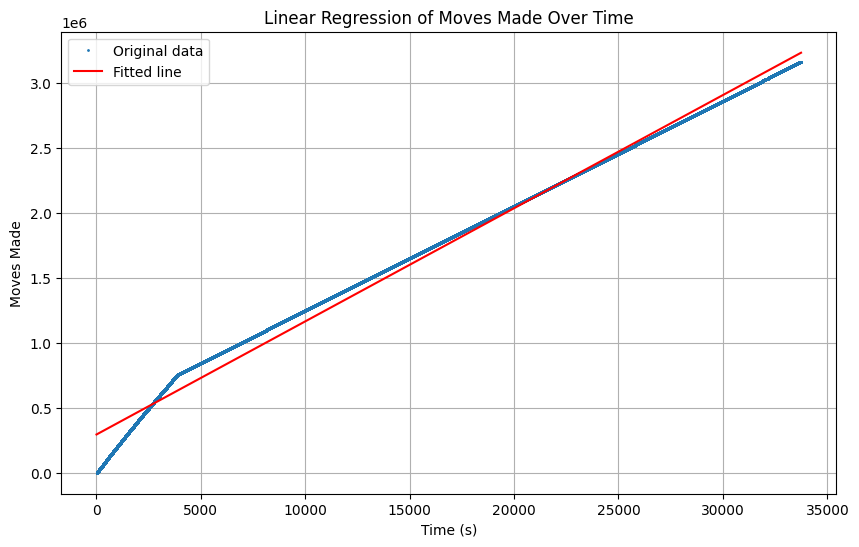

In [43]:

# Prepare the data for linear regression
x_made_move = [event[0] for event in events if event[1] == "made_move"]
y_made_move = [i for i, event in enumerate(events) if event[1] == "made_move"]

# Perform linear regression
slope_made_move, intercept_made_move, r_value_made_move, p_value_made_move, std_err_made_move = scipy.stats.linregress(x_made_move, y_made_move)

# Print the results
print(f"Slope: {slope_made_move}")
print(f"Intercept: {intercept_made_move}")
print(f"R-squared: {r_value_made_move**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x_made_move, y_made_move, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x_made_move, [slope_made_move * xi + intercept_made_move for xi in x_made_move], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Moves Made')
plt.title('Linear Regression of Moves Made Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
game_results = [event[2] for event in events if event[1] == "game_result"]

num_points = {}
for game_result in game_results:
    for key, value in game_result:
        num_points[key] = num_points.get(key, 0) + value

num_points

{'default': 67490.00000000146}

In [47]:
mcts_reports = [event[2] for event in events if event[1] == "mcts_report"]

500


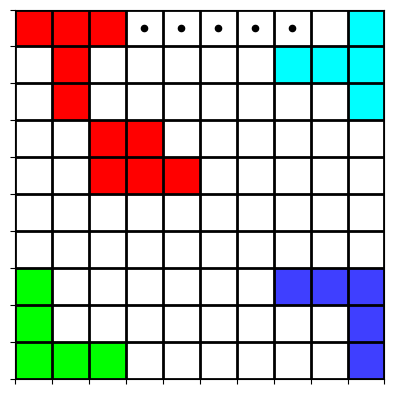

In [90]:
report = mcts_reports[89]

board = np.array(report["board"])
children_visit_counts = report["children_visit_counts"]
children_value_sums = report["children_value_sums"]
children_priors = report["children_priors"]
values = report["values"]

print(sum(children_visit_counts))

Display(board, moves_data()["new_occupieds"][70]).show()

<BarContainer object of 184 artists>

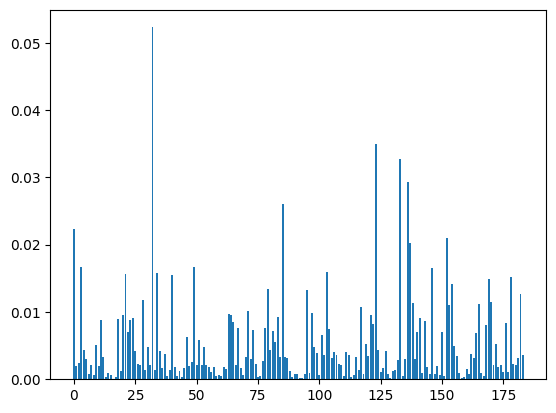

In [101]:
plt.bar(range(len(children_priors)), children_priors)

<BarContainer object of 184 artists>

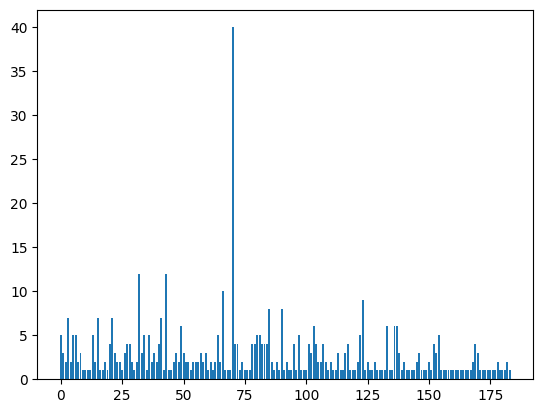

In [102]:
plt.bar(range(len(children_visit_counts)), children_visit_counts)

In [103]:
values

[0.45170801877975464,
 0.3062465786933899,
 0.10273277759552002,
 0.13931265473365784]

In [119]:
exploitation_scores = np.array(children_value_sums[1]) / np.array(children_visit_counts)

sqrt_total_visit_count = np.sqrt(np.sum(children_visit_counts) + 1)
exploration_scores = 1.4 * np.array(children_priors) * sqrt_total_visit_count / (1 + np.array(children_visit_counts))

<BarContainer object of 184 artists>

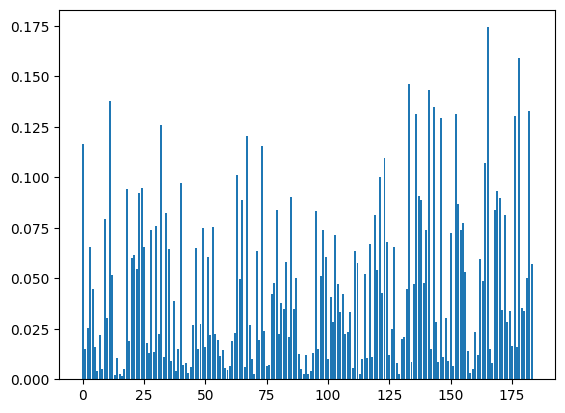

In [120]:
plt.bar(range(len(exploration_scores)), exploration_scores)

<BarContainer object of 184 artists>

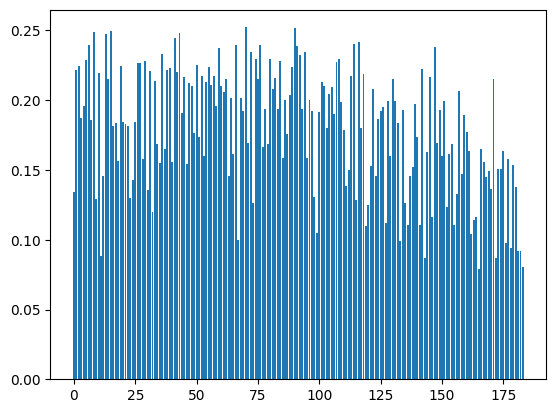

In [122]:
plt.bar(range(len(exploitation_scores)), exploitation_scores)

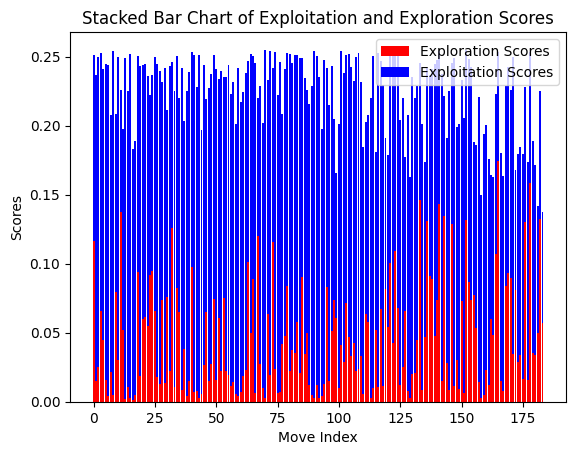

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Create a stacked bar chart
indices = range(len(exploitation_scores))
plt.bar(indices, exploration_scores, label='Exploration Scores', color='r')
plt.bar(indices, exploitation_scores, bottom=exploration_scores, label='Exploitation Scores', color='b')

plt.xlabel('Move Index')
plt.ylabel('Scores')
plt.title('Stacked Bar Chart of Exploitation and Exploration Scores')
plt.legend()
plt.show()


<BarContainer object of 184 artists>

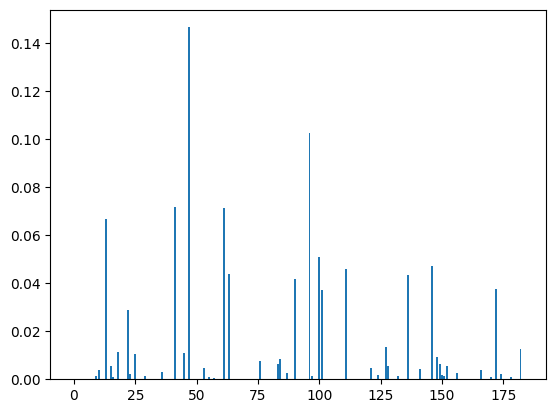

In [127]:
data = np.random.dirichlet([10.83 / len(exploration_scores)] * len(exploration_scores))
plt.bar(range(len(data)), data)

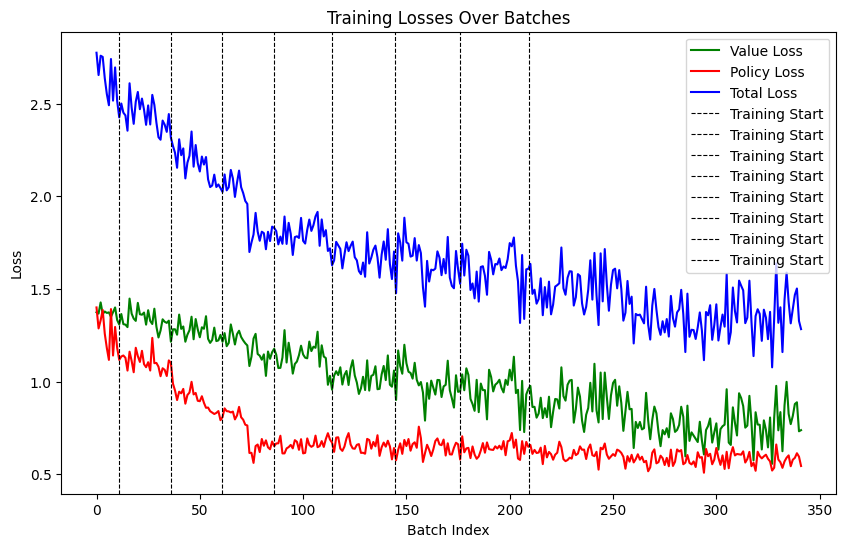